In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams 
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import os
import xgboost as xgb
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
g_train = nx.read_edgelist('/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/train_withEdge.csv', delimiter=',', create_using=nx.DiGraph() , nodetype=int)
print(nx.info(g_train))


DiGraph with 1780722 nodes and 7550015 edges


## Cosine distance
Cosine distance is a metric used to measure how similar the documents are irrespective of their size. Cosine distance can be thought of as a complement of cosine similarity. Similarity increases when distance between two points decreases and vice versa.

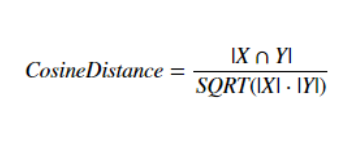

Here we are calculating the cosine distances for followers and followees of all the node pairs.

In [ ]:
def cosineFollowees(u,v):
    try:
        if len(set(g_train.successors(u))) == 0  | len(set(g_train.successors(v))) == 0:
            return 0
        cosine_similarity = (len(set(g_train.successors(u)).intersection(set(g_train.successors(v)))))/(math.sqrt(len(set(g_train.successors(u)))*len((set(g_train.successors(v))))))
        return cosine_similarity
    except:
        return 0


In [ ]:
def cosineFollowers(u,v):
    try:
        
        if len(set(g_train.predecessors(u))) == 0  | len(set(g_train.predecessors(v))) == 0:
            return 0
        cosine_similarity = (len(set(g_train.predecessors(u)).intersection(set(g_train.predecessors(v)))))/ (math.sqrt(len(set(g_train.predecessors(u))))*(len(set(g_train.predecessors(v)))))
        return cosine_similarity
    except:
        return 0

## Page Ranking
PageRank is a popular algorithm that Google uses to search and rank pages on the web to provide relevant results in their search engine results page. PageRank works by counting the number and quality of links to a page (nodes in this case) to determine a rough estimate of how important the website (node) is. Consider a user A to be very important, i.e A has a lot of connections. B and C are A’s friends. The probability that C would be B's friend is higher than of D who has less connections. \\
Here, we want to calculate the PageRank around a each node pair (source and destination) in the training set.


In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/page_rank.p'):
    pg_rank = nx.pagerank(g_train, alpha=0.8)
    pickle.dump(pg_rank,open('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/page_rank.p','wb'))
else:
    pg_rank = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/page_rank.p','rb'))

In [ ]:
#for imputing to nodes which are not there in Train data
mean_pg_rank = float(sum(pg_rank.values())) / len(pg_rank)
print(mean_pg_rank)

5.615699699262599e-07


## Jaccard Distance
The jaccard Index measures the similarity between finite sets, and is defined as the size of intersection divided by the union of the sample sets. The Jaccard distance which measures the similarity between sample sets is complimentary to jaccard index and is obtained by subtracting the jaccard index by 1. \\

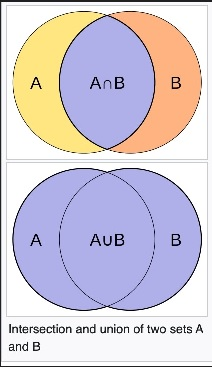

We will be calculating the jaccard distance between the followers and followees of each node pair in the training set.

In [ ]:
def jaccardFollowees(u, v):
    try:
        if len(set(g_train.successors(u))) == 0  | len(set(g_train.successors(v))) == 0:
            return 0
        jaccard_similarity = (len(set(g_train.successors(u)).intersection(set(g_train.successors(v)))))/\
                                    (len(set(g_train.successors(u)).union(set(g_train.successors(v)))))
    except:
        return 0
    return jaccard_similarity

In [ ]:
def jaccardFollowers(u, v):
    try:
        if len(set(g_train.predecessors(u))) == 0  | len(set(g_train.predecessors(v))) == 0:
            return 0
        jaccard_similarity = (len(set(g_train.predecessors(u)).intersection(set(g_train.predecessors(v)))))/\
                                 (len(set(g_train.predecessors(u)).union(set(g_train.predecessors(v)))))
        return jaccard_similarity
    except:
        return 0

## Some other features

### Follows Back?
To check if a person follows the other person back or not.

In [ ]:
def followsBack(u,v):
    return 1 if g_train.has_edge(v,u) else 0

### HITS Score
Hyper-link induced topic search (HITS) identifies good authorities and hubs for a topic by assigning two numbers to a node : an authority and a hub weight. Authorities estimate the node value based on the incoming links. Hubs estimates the node value based on outgoing links.\\
Here, in this context, it is used for understanding the importance of the node based on incoming link (hub) and outgoing link (authority)

In [ ]:
hits_score = nx.hits(g_train, max_iter=100, tol=1e-08, nstart=None, normalized=True)
pickle.dump(hits_score,open('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/hitscore.p','wb'))

In [ ]:

print('min',hits_score[0][min(hits_score[0], key=hits_score[0].get)])
print('max',hits_score[0][max(hits_score[0], key=hits_score[0].get)])
print('mean',float(sum(hits_score[0].values())) / len(hits_score[0]))

min -1.0879811303501434e-20
max 0.004868653379538981
mean 5.615699699308681e-07


### Shortest Path
Shortest path is the path between two nodes such that the sum of their weights is minimum. We are calculating the shortest path between every node pair in our data.

In [ ]:
def shortestPath(u,v):
    p=-1
    try:
        if g_train.has_edge(u,v):
            g_train.remove_edge(u,v)
            p= nx.shortest_path_length(g_train,source=u,target=v)
            g_train.add_edge(u,v)
        else:
            p= nx.shortest_path_length(g_train,source=u,target=v)
        return p
    except:
        return -1

### Checking for same community
Each weakly connected subgraph is a community. As discussed in exploration there might be some nodes that are disconnected from other nodes. Hence this becomes an important feature for our model. 
Here we are checking if node u and v belong to the same community (subgraph) or not.

In [ ]:
from networkx.algorithms.components.weakly_connected import weakly_connected_components
#getting weekly connected edges from graph 
weeklycc=list(nx.weakly_connected_components(g_train))
def sameWCC(u,v):
    index = []
    if g_train.has_edge(v,u):
        return 1
    if g_train.has_edge(u,v):
            for e in weeklycc:
                if u in e:
                    index= e
                    break
            if (v in index):
                g_train.remove_edge(u,v)
                if shortestPath(u,v)==-1:
                    g_train.add_edge(u,v)
                    return 0
                else:
                    g_train.add_edge(u,v)
                    return 1
            else:
                return 0
    else:
            for e in weeklycc:
                if u in e:
                    index= e
                    break
            if(v in index):
                return 1
            else:
                return 0

## Featurization
Once, after defining all the features, we now map the features to the train and test dataset

In [ ]:
filename = "/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/train_final.csv"
num_train =  15100028
sample_size = 100000 #desired sample size
skip_tr = sorted(random.sample(range(1,num_train+1),num_train-sample_size))

In [ ]:
filename = "/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/test_final.csv"
num_test = 3775006
sample_size = 50000 #desired sample size
skip_te = sorted(random.sample(range(1,num_test+1),num_test-sample_size))

In [ ]:
df_trainFinal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/train_final.csv', skiprows=skip_tr , names=['src', 'dst'])
df_trainFinal['ind_lnk'] = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Facebook/train_y.csv', skiprows=skip_tr , names=['ind_lnk'])
print("Size of train: ",df_trainFinal.shape)
df_trainFinal.head(2)

Size of train:  (100002, 3)


,src,dst,ind_lnk
0,273084,1505602,1
1,730672,1840032,1


In [ ]:
df_testFinal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/test_final.csv', skiprows=skip_te , names=['src', 'dst'])
df_testFinal['ind_lnk'] = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Facebook/test_y.csv', skiprows=skip_te , names=['ind_lnk'])
print("Size of test: ", df_testFinal.shape)
df_testFinal.head(2)

Size of test:  (50002, 3)


,src,dst,ind_lnk
0,848424,784690,1
1,701202,342277,1


Mapping cosine distance and jaccard distance

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/storedStage1.h5'):
    df_trainFinal['c_followers'] = df_trainFinal.apply(lambda row:
                                            cosineFollowers(row['src'],row['dst']),axis=1)
    df_testFinal['c_followers'] = df_testFinal.apply(lambda row:
                                            cosineFollowers(row['src'],row['dst']),axis=1)

    df_trainFinal['c_followees'] = df_trainFinal.apply(lambda row:
                                            cosineFollowees(row['src'],row['dst']),axis=1)
    df_testFinal['c_followees'] = df_testFinal.apply(lambda row:
                                            cosineFollowees(row['src'],row['dst']),axis=1)
    df_trainFinal['j_followers'] = df_trainFinal.apply(lambda row:
                                            jaccardFollowers(row['src'],row['dst']),axis=1)
    df_testFinal['j_followers'] = df_testFinal.apply(lambda row:
                                            jaccardFollowers(row['src'],row['dst']),axis=1)

    df_trainFinal['j_followees'] = df_trainFinal.apply(lambda row:
                                            jaccardFollowees(row['src'],row['dst']),axis=1)
    df_testFinal['j_followees'] = df_testFinal.apply(lambda row:
                                            jaccardFollowees(row['src'],row['dst']),axis=1)

Finding total followers and followees for source and destination nodes

In [ ]:
def featurizationPhase1(finalData):
    totalFollowerSource=[]
    totalFolloweeSource=[]
    totalFollowerDestin=[]
    totalFolloweeDestin=[]
    followerIntersect=[]
    followeeIntersect=[]
    for i,row in finalData.iterrows():
        try:
            s1=set(g_train.predecessors(row['src']))
            s2=set(g_train.successors(row['src']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(g_train.predecessors(row['dst']))
            d2=set(g_train.successors(row['dst']))
        except:
            d1 = set()
            d2 = set()
        totalFollowerSource.append(len(s1))
        totalFolloweeSource.append(len(s2))

        totalFollowerDestin.append(len(d1))
        totalFolloweeDestin.append(len(d2))

        followerIntersect.append(len(s1.intersection(d1)))
        followeeIntersect.append(len(s2.intersection(d2)))
    
    return totalFollowerSource, totalFollowerDestin, totalFolloweeSource, totalFolloweeDestin, followerIntersect, followeeIntersect

Mapping the followers and followees of source and destination node to train and test dataset

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/storedStage1.h5'):
    df_trainFinal['totalFollowerSource'], df_trainFinal['totalFollowerDestin'], \
    df_trainFinal['totalFolloweeSource'], df_trainFinal['totalFolloweeDestin'], \
    df_trainFinal['followerIntersect'], df_trainFinal['followeeIntersect']= featurizationPhase1(df_trainFinal)
    
    df_testFinal['totalFollowerSource'], df_testFinal['totalFollowerDestin'], \
    df_testFinal['totalFolloweeSource'], df_testFinal['totalFolloweeDestin'], \
    df_testFinal['followerIntersect'], df_testFinal['followeeIntersect']= featurizationPhase1(df_testFinal)
    
    hdf = HDFStore('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/storedStage1.h5')
    hdf.put('train_df',df_trainFinal, format='table', data_columns=True)
    hdf.put('test_df',df_testFinal, format='table', data_columns=True)
    hdf.close()
else:
    df_trainFinal = read_hdf('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/storedStage1.h5', 'train_df',mode='r')
    df_testFinal = read_hdf('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/storedStage1.h5', 'test_df',mode='r')

Mapping of shortest distance , follows back, and same connected components to the train and test dataset

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/storedStage2.h5'):
    df_trainFinal['min_dist'] = df_trainFinal.apply(lambda row: shortestPath(row['src'],row['dst']),axis=1)
    df_testFinal['min_dist'] = df_testFinal.apply(lambda row: shortestPath(row['src'],row['dst']),axis=1)

    df_trainFinal['folo_bck'] = df_trainFinal.apply(lambda row: followsBack(row['src'],row['dst']),axis=1)
    df_testFinal['folo_bck'] = df_testFinal.apply(lambda row: followsBack(row['src'],row['dst']),axis=1)

    df_trainFinal['same_cc'] = df_trainFinal.apply(lambda row: sameWCC(row['src'],row['dst']),axis=1)
    df_testFinal['same_cc'] = df_testFinal.apply(lambda row: sameWCC(row['src'],row['dst']),axis=1)
  
    hdf = HDFStore('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/storedStage2.h5')
    hdf.put('train_df',df_trainFinal, format='table', data_columns=True)
    hdf.put('test_df',df_testFinal, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/storedStage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/storedStage2.h5', 'test_df',mode='r')

Calculation of weights of source and destination

In [ ]:
wgh_in = {}
wgh_out = {}
for i in  tqdm(g_train.nodes()):
    s1=set(g_train.predecessors(i))
    wi = 1.0/(np.sqrt(1+len(s1)))
    wgh_in[i]=wi
    
    s2=set(g_train.successors(i))
    wo = 1.0/(np.sqrt(1+len(s2)))
    wgh_out[i]=wo
    
#for imputing with mean
mean_w_in = np.mean(list(wgh_in.values()))
mean_w_o = np.mean(list(wgh_out.values()))

100%|██████████| 1780722/1780722 [00:18<00:00, 96796.81it/s] 


Mapping of weights to train and test data

In [ ]:
df_trainFinal['wgh_in'] = df_trainFinal.dst.apply(lambda x: wgh_in.get(x,mean_w_in))
df_trainFinal['wgh_out'] = df_trainFinal.src.apply(lambda x: wgh_out.get(x,mean_w_o))
df_testFinal['wgh_in'] = df_testFinal.dst.apply(lambda x: wgh_in.get(x,mean_w_in))
df_testFinal['wgh_out'] = df_testFinal.src.apply(lambda x: wgh_out.get(x,mean_w_o))

df_trainFinal['wgh_f1'] = df_trainFinal.wgh_in + df_trainFinal.wgh_out
df_trainFinal['wgh_f2'] = df_trainFinal.wgh_in * df_trainFinal.wgh_out
df_trainFinal['wgh_f3'] = (2*df_trainFinal.wgh_in + 1*df_trainFinal.wgh_out)
df_trainFinal['wgh_f4'] = (1*df_trainFinal.wgh_in + 2*df_trainFinal.wgh_out)

df_testFinal['wgh_f1'] = df_testFinal.wgh_in + df_testFinal.wgh_out
df_testFinal['wgh_f2'] = df_testFinal.wgh_in * df_testFinal.wgh_out
df_testFinal['wgh_f3'] = (2*df_testFinal.wgh_in + 1*df_testFinal.wgh_out)
df_testFinal['wgh_f4'] = (1*df_testFinal.wgh_in + 2*df_testFinal.wgh_out)

Mapping of page rank to train and test data

In [ ]:
#page rank for source and destination in Train and Test
#if anything not there in train graph then adding mean page rank 
df_trainFinal['pr_src'] = df_trainFinal.src.apply(lambda x:pg_rank.get(x,mean_pg_rank))
df_trainFinal['pr_dst'] = df_trainFinal.dst.apply(lambda x:pg_rank.get(x,mean_pg_rank))

df_testFinal['pr_src'] = df_testFinal.src.apply(lambda x:pg_rank.get(x,mean_pg_rank))
df_testFinal['pr_dst'] = df_testFinal.dst.apply(lambda x:pg_rank.get(x,mean_pg_rank))

Mapping of HITS Score to train and test data

In [ ]:
#Hits algorithm score for source and destination in Train and test
#if anything not there in train graph then adding 0
df_trainFinal['hubs_s'] = df_trainFinal.src.apply(lambda x: hits_score[0].get(x,0))
df_trainFinal['hubs_d'] = df_trainFinal.dst.apply(lambda x: hits_score[0].get(x,0))

df_testFinal['hubs_s'] = df_testFinal.src.apply(lambda x: hits_score[0].get(x,0))
df_testFinal['hubs_d'] = df_testFinal.dst.apply(lambda x: hits_score[0].get(x,0))
 
#Hits algorithm score for source and destination in Train and Test
#if anything not there in train graph then adding 0
df_trainFinal['authorities_s'] = df_trainFinal.src.apply(lambda x: hits_score[1].get(x,0))
df_trainFinal['authorities_d'] = df_trainFinal.dst.apply(lambda x: hits_score[1].get(x,0))

df_testFinal['authorities_s'] = df_testFinal.src.apply(lambda x: hits_score[1].get(x,0))
df_testFinal['authorities_d'] = df_testFinal.dst.apply(lambda x: hits_score[1].get(x,0))

hdf = HDFStore('/content/drive/MyDrive/Colab Notebooks/Facebook/featurized_data/storedStage3.h5')
hdf.put('train',df_trainFinal, format='table', data_columns=True)
hdf.put('test',df_testFinal, format='table', data_columns=True)
hdf.close()

In [ ]:
#References
  #https://stackoverflow.com/a/22259008/4084039
  #https://stackoverflow.com/a/22259008/4084039